<a href="https://colab.research.google.com/github/aminedahire/Lab-SSL/blob/main/Copy_of_Self_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning
!pip install wandb

USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

import wandb
if not wandb.login():
    raise ValueError("WandDB authentification failed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import os
import glob
import cv2
from torch.utils.data import Dataset, Subset, DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import SVHN as torch_SVHN
from torchvision.models import resnet18, resnet50
from torchvision.datasets.utils import extract_archive
from pytorch_lightning.loggers import WandbLogger
import cv2 as cv
from torchmetrics.functional import accuracy
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

def imshow(img):
    if isinstance(img, torch.Tensor):
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

<center><h1> Self Supervised Learning</h1></center>

<div Align= 'justify'>In all of the previous classification tasks, we had a high amount of labeled images for each classes. This allows our model to properly learn and generally achieve good accuracy given enough images. However, we often **don't have access** to a high amount of labeled data; but only a **small set of labeled data** and a bigger set of unlabeled data.

Therefore, we would be interested in a learning strategy that would enable us to **extract useful information from the unlabeled image** set for a simpler representations (Representation Learning) and then use the labeled samples to learn a classifier on these representations (Fine-tunning Classification). One simple yet successful approach has been the use of pretext tasks. **Pretext tasks** learning consists in considering an **auxiliary task**, different from our target task, and learn a network by solving this task. Then, we only keep part of the network as a representation encoder. The full process is summarized bellow: </div>


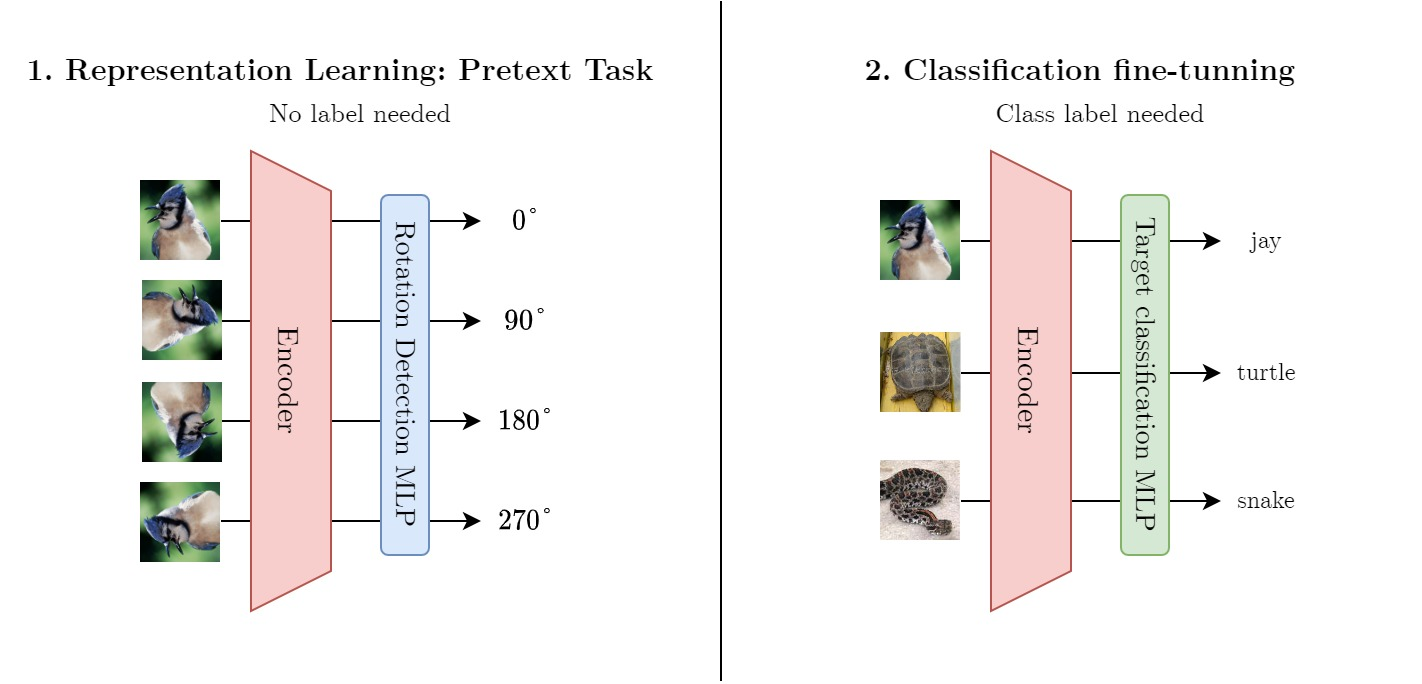


Pretext tasks are a part of self-supervised learning methods that formulate a supervised learning scheme from unlabeled data.


**Goal of this lab** :
* Understand how representation learning through pretext tasks works
* Practice fine-tuning
* Overview some other applications of pretext tasks
* Reuse Pytorch Lightning

# I - Industrial Task 1 : Classifying street number with few labeled data

<div Align="justify">Let imagine that you want to recognize street numbers from street view imagery. Since you have free access to many street photos containing street numbers, you can obtain a huge amount of pictures of street numbers (let put aside how you extract and isolate them from full street images). However, you don't have the label (number) information for each of these images. Consequently, you painstakingly go over the first 1000 images and manually label them. Tools like LabelImg, CVAT are your best friends for a while..</div>


<div Align="justify">You are in a semi-supervised setting where you have access to a high amount of street number images but only 1% of labeled data.

In this first part you will evaluate **how pretext tasks can be applied to help you leverage the informations in the unlabeled set to achieve good classification performances.** </div>

## 1 - Street View House Numbers

To reproduce the aformentionned scenario, we will be using the Street View House Numbers (SVHN) dataset, and remove 99% of the labels of the training data.

In [3]:
class SVHN(Dataset):
    def __init__(self, root, split, download=True, label_p=0.01, **kwargs):
        if split == "test":
            self.keep_label, self.base_dt = True, torch_SVHN(root, split='test', download=download, **kwargs)
        else:
            dt_train = torch_SVHN(root, split='train', download=download, **kwargs)
            labeled_size = int(label_p * len(dt_train))
            unlabeled_size = len(dt_train) - labeled_size
            torch.manual_seed(42)
            dt_train_unlabeled, dt_train_labeled =  torch.utils.data.random_split(dt_train, [unlabeled_size, labeled_size])
            if split == "train_labeled":
                self.keep_label, self.base_dt = True, dt_train_labeled
            elif split == "train_unlabeled":
                self.keep_label, self.base_dt = False, dt_train_unlabeled

    def __getitem__(self, k):
        if self.keep_label:
            return self.base_dt[k]
        return self.base_dt[k][0]

    def __len__(self):
        return len(self.base_dt)

First of all, perform an Exploratory Data Analysis (EDA) on the SVHN Dataset :

1.   What type of Data do you have ? (Images, Texts, Sound..)
2.   How many Data do you have ?
3.   What's in a sample (1 element of the Dataset)
4.   Is the Dataset unbalanced ?
5.   What's the shape of any input sample ?
6.   ....


100%|██████████| 182040794/182040794 [00:34<00:00, 5260838.67it/s]


Using downloaded and verified file: ./train_32x32.mat
Number of labeled samples: 732
Number of unlabeled samples: 72525
Sample Image Shape: (32, 32)
Sample Label: 3


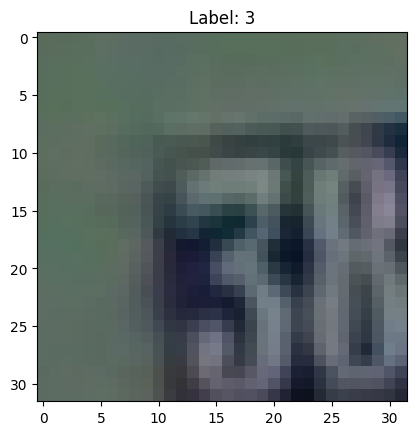

In [4]:
# Loading the Training Splits of SVHN Dataset
dataset_train  = SVHN('.', split='train_labeled', download=True) # Labeled Dataset
dataset_train_ul = SVHN('.', split='train_unlabeled', download=True) # Unlabeled Dataset

# TODO :
# What is the amount of labeled and unlabeled data ?
print("Number of labeled samples:", len(dataset_train))
print("Number of unlabeled samples:", len(dataset_train_ul))

# What is in a sample ? Print the sample to understand
sample_idx = 1
sample, label = dataset_train[sample_idx]
print("Sample Image Shape:", sample.size)
print("Sample Label:", label)


# Plot the image in the sample.
plt.imshow(sample)
plt.title(f"Label: {label}")
plt.show()

We start by defining a datamodule for the labeled classification.

**TODO**: Using your previous knowledge of datamodule declaration, fully define a datamodule for the **labeled data** from the previously defined Dataset `SVHN` that we will try to solve the digit classification task from.
- Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`
* `def test_dataloader(self)`.


The validation data should be sampled from the training data with a ratio of 25%.

In [5]:
class SVHNDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size

    # TODO : As usual, complete the datamodule

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            # Initialize the labeled training dataset
            self.train_dataset = SVHN(self.data_dir, split='train_labeled',transform=self.transform, download=True)
            # Initialize the validation dataset from the labeled training dataset
            # You can use a split ratio or a fixed number for validation
            train_size = int(0.75 * len(self.train_dataset))
            val_size = len(self.train_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(self.train_dataset, [train_size, val_size])

        if stage == 'test' or stage is None:
            # Initialize the test dataset
            self.test_dataset = SVHN(self.data_dir, split='test',transform=self.transform, download=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


## 2 - SVHN Classifier from scratch

In a first time, we will directly train a classifier on the few labeled data and evaluate its accuracy on the test set.

 **<center>You are free to design the architecture of your model.</center>**

To facilitate the next sections, we will split the model into two parts:
1. **The encoder**: the succession of conv filters. Its role is to convert our images into useful representations
2. **The classifier**: an MLP which role is to predict the label given the representations

We will be using a well-known backbone for the encoder: a resnet18.

Some advices for the choice of architecture:

For the encoder sequence of nn.Conv2D filter size of 3, and stride or maxpooling

Make sure the linear size match, you can print your input size in the forward method of your model to help or use torchsummary.

In [6]:
class SVHNEncoder(nn.Module):
    """
    Model encoder.
    """
    def __init__(self):
        super().__init__()
        self.backbone = resnet18()
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)


class SVHNClassifier(nn.Module):
    """
    Model classifier.
    """
    def __init__(self, n_class):
        super().__init__()
        # TODO : Define your classifier model (with n_class classes) here.
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_class)
        )

    def forward(self, x):
        # TODO : Forward x
        return self.classifier(x)


class SVHNModel(pl.LightningModule):
    """
    Full SVHN lightning module.
    """
    def __init__(self, lr=1e-1):
        super().__init__()
        self.encoder = SVHNEncoder() # TODO : Define your Encoder
        self.classifier = SVHNClassifier(n_class=10) # TODO : Define your Classifier. What is n_class ?
        self.lr = lr

    def forward(self,x):
        # TODO: Forward x
        features = self.encoder(x)
        return self.classifier(features)

    def configure_optimizers(self):
        # TODO : Define your optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # This method is pretty much similar to what your did in the MNIST classification.
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)


    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x, y = batch
        y_hat = self.forward(x)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=10, task='multiclass')
        self.log('test_acc', acc, on_epoch=True)



### Training

<div Align='justify'>For all the training in this lab, we will be using 'Weights & Biases' (w&b) as the logger. WandB is used in lots of companies as it provides a hassle free logging interface. It is generally more powerful and convenient to use than Tensorboard. As Tensorboard, WandB is also deployable in productions. In our case, we will use the cloud version hosted by WandB. In all of these experiments, our experiments will be logged and sent to a specific link which will be provided by WandB.</div>

Launch the Training on the `SVHNDataModule`.

In [7]:
# TODO :
model = SVHNModel()
batch_size = 64
dm = SVHNDataModule(data_dir='.', batch_size=batch_size)
logger = WandbLogger(name='SVHN_scratch',project='SVHN_classif')
trainer = pl.Trainer(accelerator='auto',
                     max_epochs=20,
                     default_root_dir="SVHN_classification",
                     logger=logger)
trainer.fit(model, dm)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: amine-dahire. Use `wandb login --relogin` to force relogin


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type           | Params
----------------------------------------------
0 | encoder    | SVHNEncoder    | 11.2 M
1 | classifier | SVHNClassifier | 133 K 
----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.242    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇██
train_loss,▂█▁
trainer/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇██
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
train_loss,2.20086
trainer/global_step,179
val_loss,2.26724


### Testing


In [8]:
# TODO : Evaluate your model using the LightningModule test method.
trainer = pl.Trainer(accelerator='auto', default_root_dir="SVHN_classification")


trainer.test(model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 64275384/64275384 [00:09<00:00, 6522031.18it/s] 
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19587430357933044    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.19587430357933044}]

* Do you consider the model to be accurate ?
* Try to increase the number of epochs. What do you observe when looking at the training and validation losses ?
* Why do you think this occurs ?

## 3 - SVHN Classifier with pretext-task self-supervision

In the previous part, we have only used the labeled data for the training leaving us with too few training samples. To leverage the unlabeled data, we will now learn beforehand to solve a pretext task, and then fine-tune classification on the extracted representations. We will be using a simple pretext task: the 90° rotation recognition.

 The goal is to **classify the angle of the rotation applied on an image from {0°, 90°, 180°, 270°}.**

### i - Solving the pretext task

We will design a new datamodule that will encompass the pretext data samples with their labels from an unlabeled dataset.

* Complete the following dataset, that should be initialized from an unlabeled dataset, and provide one of the 4 rotations for each samples' image with the corresponding label.

In [9]:
class PretextTask(Dataset):
    def __init__(self, ul_dataset):
        self.ul_dataset = ul_dataset

    def __len__(self):
        return len(self.ul_dataset)

    def __getitem__(self, k):
        image = self.ul_dataset[k]
        rot_k = random.choice([0, 1, 2, 3])

        # Rotate the image
        rotated_image = torch.rot90(image, rot_k, [1, 2])
        return rotated_image, rot_k


* Fully define a LightningDatamodule for the pretext task labeled data of the SVHN unlabeled data.

Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`

(we **won't be using any test data in the pretext task**).
- The validation data should be sampled from the training data with a ratio of 20%.
- The returned dataloader should be shuffled (option `shuffle=True`).

In [10]:
class SVHNPretextDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        nn.Linear(512, 4)
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size

    # TODO : As Usual Define the rest of this class
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            ul_dataset = SVHN(self.data_dir, split='train_unlabeled', transform=self.transform, download=True)
            pretext_dataset = PretextTask(ul_dataset)
            train_size = int(0.8 * len(pretext_dataset))
            val_size = len(pretext_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(pretext_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)



**TODO**: Visualize a few images from `SVHNPretextDataModule::train_dataloader` to check your implementation (the function `imshow(img)` is provided to easily plot a tensor image or numpy image).

Using downloaded and verified file: ./train_32x32.mat
Label (Rotation): 270°


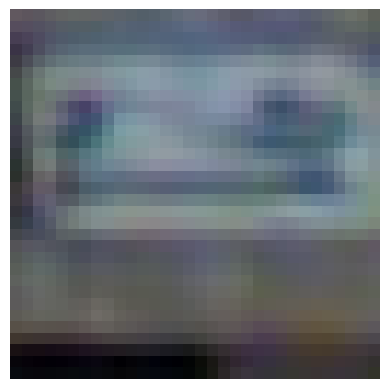

Label (Rotation): 180°


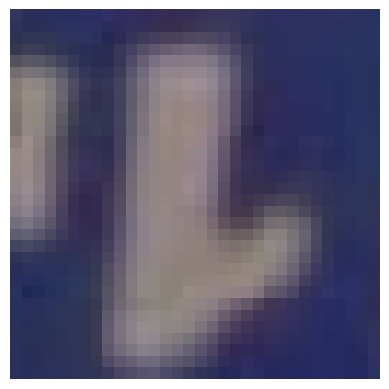

Label (Rotation): 270°


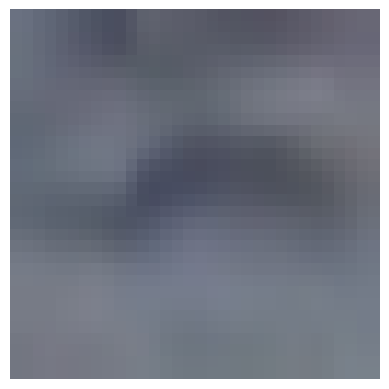

Label (Rotation): 180°


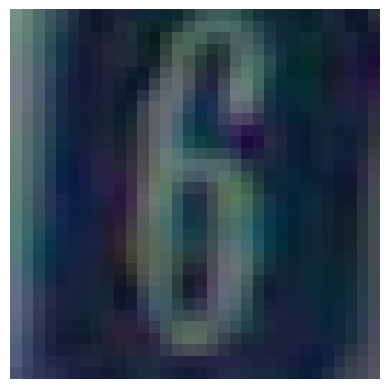

In [11]:
dl = SVHNPretextDataModule(".", 32)
dl.setup(None)

# TODO : Plot

# Get the train dataloader
train_loader = dl.train_dataloader()

# Fetch a batch of images
images, labels = next(iter(train_loader))

# Visualize a few images
for i in range(4):
    img = images[i]
    label = labels[i].item()
    print(f"Label (Rotation): {label * 90}°")
    imshow(img)

We now define our LightningModule for the pretext task learning. It is important to note that the **encoder architecture must be the same** as in the final task of digit classification. Although we are free to choose the classifier, we will reuse the SVHNClassifier class.

In [12]:
class SVHNPretextModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # TODO : Init your Model
        self.encoder = resnet18(pretrained=True)
        self.encoder.fc = nn.Identity()
        self.classifier = nn.Linear(512, 4)

    def forward(self,x):
        # TODO.
        features = self.encoder(x)
        out = self.classifier(features)
        return out


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), 1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1),y, num_classes=4, task='multiclass')
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # We will also be logging our val accuracy here.
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y,num_classes=4, task='multiclass')
        self.log('val_loss', loss)
        self.log('val_acc', acc)


#### Training

Train your Model

In [13]:
# TODO : Train
pretext_model = SVHNPretextModel()
batch_size = 32
dm = SVHNPretextDataModule(data_dir='.', batch_size=batch_size)
dm.setup(stage='fit')
logger=WandbLogger(name='SVHN_rot',project='SVHN_pretext')
trainer = pl.Trainer(accelerator='auto',
                     max_epochs=10,
                     default_root_dir="SVHN_pretext",
                     val_check_interval=0.25,
                     logger=logger)
trainer.fit(pretext_model, dm)
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params
--------------------------------------
0 | encoder    | ResNet | 11.2 M
1 | classifier | Linear | 2.1 K 
--------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_acc,▁▅▅▄▃▆▄▅▃▅▇▆▇▆▇▇▆▆▅▆▇▅▆▄▆▆▇▇▇▇▆▆█▆▇▆▆▆▇▅
train_loss,█▅▄▆▅▃▅▅▅▃▃▃▂▃▂▂▄▃▄▄▂▄▄▅▂▃▁▁▂▂▂▃▁▇▁▃▂▃▂▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▆▆▇▇▇██▇▇█▇███▇▇████
val_loss,▇█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▂▁▂▁▁
epoch,9
train_acc,0.8125
train_loss,0.37413
trainer/global_step,18137
val_acc,0.88314


### ii - Classification fine-tunning

We will now reuse the learnt pretext task encoder as an initialization for digit classification.

#### Training

We will load the checkpoint of the pretext task encoder, and use its weights as an initialization of our final classification encoder. There are many ways to perform fine-tunning from a pretrained network; here we choose to freeze all the weights of the encoder and only train the classifier on the labeled data.

In [16]:
class SVHNClassificationModel(pl.LightningModule):
    def __init__(self, pretrained_encoder):
        super().__init__()
        self.encoder = pretrained_encoder
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        features = self.encoder(x)
        out = self.classifier(features)
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=10, task='multiclass')
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=10, task='multiclass')
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=10, task='multiclass')
        self.log('test_loss', loss)
        self.log('test_acc', acc)

In [17]:
# Reload the best pretext model.
# TODO: Check that the following path matches your best pretext task training checkpoint directory.
pretext_checkpoint_dir = "/content/SVHN_pretext/ltws1fix/checkpoints"
best_ckpt = glob.glob(os.path.join(CONTENT_DIR, pretext_checkpoint_dir, "*.ckpt"))[0]
print("Loading checkpoint from", best_ckpt)
pretext_model = SVHNPretextModel.load_from_checkpoint(best_ckpt)
pretext_model.freeze()

# TODO: Create the SVHN classification model and use the encoder from the pretext model.

model = SVHNClassificationModel(pretext_model.encoder)
dm = SVHNDataModule(data_dir='.', batch_size=32)
dm.setup(stage='test')
logger = WandbLogger(name='SVHN_finetune',project='SVHN_classif')
trainer = pl.Trainer(accelerator='auto',
                     max_epochs=100,
                     default_root_dir="SVHN_classification",
                     logger=logger)
trainer.fit(model, dm)
trainer.test(model, datamodule=dm)
wandb.finish()

Loading checkpoint from /content/SVHN_pretext/ltws1fix/checkpoints/epoch=9-step=18138.ckpt
Using downloaded and verified file: ./test_32x32.mat


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params
--------------------------------------
0 | encoder    | ResNet | 11.2 M
1 | classifier | Linear | 5.1 K 
--------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Using downloaded and verified file: ./test_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.28918254375457764    │
│         test_loss         │    2.0535411834716797     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_acc,▁
test_loss,▁
train_acc,▆▅▆▆▅▅▅▆▄▅▅▇▅█▅▅▆▄▇▆▇▆▄▆▃▆▄▆▅▆▅▆▆▅▇▁
train_loss,▂▂▂▁▂▂▂▂▄▂▂▁▂▂▂▂▁▄▁▂▁▁▂▂▃▁█▂▂▂▂▂▂▁▂▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▆▅▆▅▄▅▆▅▅▆▆▆▅▆▇▆▄▇▅▅▇▄▇▆▆▇▇▆▆█▇█▇▆▇▇▇▇
val_loss,██▅▅▄▃▄▃▂▃▂▂▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▂▂▁▂▂▂▁▁▂
epoch,100
test_acc,0.28918
test_loss,2.05354


Pytorch lightning first displays a summary of the training parameters.

* What difference do you observe by comparing it to the training from scratch ?
* Why is it so ?

### Testing

* Test some images from the testing dataset to verify that your model works.

* Do you consider the model to be accurate ?
* Has the pretext task pretraining on the unlabeled data helped to improve the performance of the classifier from scratch ?

We note that for longer training times, the benefits of the self-supervised training would be more significant.

# II - Industrial Task 2 : Anomaly Detection on faces

In this last section, we will show an application of pretext tasks for anomaly detection. The main idea is that a model trained to solve a pretext task on some normal data will be less efficient on solving this task on very different data.

In particular we will learn to solve the 90° rotation detection task on the celebA dataset. The celebA dataset contains many images of celebrities which will be our normal face class samples. We have reduced the amount of samples and the size of the images to 64x64.

In [18]:
# Download and extract CelebA dataset.
!pip install gdown
!gdown --id 1DisQMhb1fnmXGCC-JGqUTu2l7d5E1ihI
celeba_dname = os.path.join(CONTENT_DIR, "CelebA")
celeba_fname = os.path.join(CONTENT_DIR, "celebA_subset.zip")
os.makedirs(celeba_dname, exist_ok=True)
extract_archive(celeba_fname, celeba_dname)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DisQMhb1fnmXGCC-JGqUTu2l7d5E1ihI
To: /content/celebA_subset.zip
100% 60.3M/60.3M [00:00<00:00, 127MB/s]


'/content/CelebA'

In [19]:
# Loading the celebA dataset.
class CelebA(Dataset):
    def __init__(self, root, split, transform=None, **kwargs):
        ds_dname = os.path.join(root, "CelebA")
        if not os.path.exists(ds_dname):
            raise FileNotFoundError(ds_dname)

        self.fnames = glob.glob(os.path.join(ds_dname, {"test": "Test", "train": "Train", "valid": "Eval"}[split], "*.jpg"))
        self.transform = transform

    def __getitem__(self, k):
        fname = self.fnames[k]
        img = Image.open(fname).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.fnames)


In [20]:
class PretextTask(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the image
        image = self.dataset[idx]  # Directly getting the image

        # Apply rotation
        rot_k = random.choice([0, 1, 2, 3])
        rotated_image = torch.rot90(image, rot_k, [1, 2])

        # Return the rotated image and rotation label
        return rotated_image, rot_k

* Perform a pretext task training on the rotation detection task with the celebA data.

You should follow the same steps as in the pretext task training on the digit data, as the training is very similar
As usual, you are free to choose the architecture and optimizer

In [21]:
class CelebAPretextDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, shuffle=True):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transforms.Compose([transforms.Resize((64, 64)),
                                             transforms.ToTensor()])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            celeba_train = CelebA(root=self.data_dir, split='train', transform=self.transform)
            celeba_val = CelebA(root=self.data_dir, split='valid', transform=self.transform)
            self.train_dataset = PretextTask(celeba_train)
            self.val_dataset = PretextTask(celeba_val)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)


In [27]:
class CelebAPretextModel(pl.LightningModule):
  def __init__(self):
        super().__init__()
        self.encoder = resnet18(pretrained=True)
        self.encoder.fc = nn.Identity()
        self.classifier = nn.Linear(512, 4)

  def forward(self, x):
        features = self.encoder(x)
        out = self.classifier(features)
        return out

  def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

  def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        y = torch.randint(0, 4, (x.size(0),))
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=4, task='multiclass')
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

  def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = accuracy(torch.argmax(y_hat, dim=1), y, num_classes=4, task='multiclass')
        self.log('val_loss', loss)
        self.log('val_acc', acc)

In [29]:
# TODO : Train your model
model = CelebAPretextModel()
batch_size = 32
dm = CelebAPretextDataModule(data_dir='.', batch_size=batch_size)
dm.setup(stage='fit')
logger = WandbLogger(name='celeba', project='celeba_pretext')
trainer = pl.Trainer(accelerator='auto', max_epochs=5, default_root_dir="celeba_pretext", logger=logger)
trainer.fit(model, dm)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params
--------------------------------------
0 | encoder    | ResNet | 11.2 M
1 | classifier | Linear | 2.1 K 
--------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: ignored

Now that our model has been trained to solve the pretext task on real faces from celebA data, we expect it to solve the task quite well. More specifically, we can expect our model to be **more accurate on solving the rotation task on faces (normal data) than on other types of data outside faces (anomalies)**.

We can thus construct a very simple anomaly detector by using the softmax score corresponding to the ground-truth as a normality score. The more confident our model is on the ground-truth, the more normal we can consider the input to be.

In [24]:
def compute_anomaly_score(batch,model, is_anomaly_data=False):
    x, y = batch
    y_hat = model(x)
    soft_scores = F.softmax(y_hat, dim=1)
    if is_anomaly_data:
        y = torch.zeros_like(y)
    # Take the score corresponding to the ground truth class.
    gt_soft_scores = (soft_scores*F.one_hot(y,num_classes=4)).sum(1)
    return gt_soft_scores

We will use the CIFAR-10 dataset as the anomalous data. We now compute the anomaly scores on the normal dataset (celebA) and the anomalies (CIFAR-10).

In [26]:
normal_dm = CelebAPretextDataModule(data_dir='.', batch_size=32, shuffle=False)
normal_dm.setup(None)

model.eval()
normal_scores = []
anomaly_scores = []

with torch.no_grad():
    for batch in dm.val_dataloader():
        normal_scores.extend(compute_anomaly_score(batch, model).cpu().numpy())

    for batch in DataLoader(CIFAR10('.', train=False, download=True, transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])), batch_size=32):
        anomaly_scores.extend(compute_anomaly_score(batch, model,is_anomaly_data=True).cpu().numpy())

normal_scores = np.array(normal_scores).reshape((-1, 4)).mean(1)
anomaly_scores = np.array(anomaly_scores).reshape((-1, 4)).mean(1)

Files already downloaded and verified


AxisError: ignored

**TODO**: Plot the ROC curve and print the AUC of the anomaly detector.

In [ ]:
labels = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anomaly_scores))])
scores = np.concatenate([normal_scores, anomaly_scores])
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.2f}")

* What can you say ?